<a href="https://colab.research.google.com/github/fajrunwm/gisml/blob/main/Agriculture_Augmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agriculture Augmentation

# Phase 1: Satellite Data Transformation

## Data Preparation

In [ ]:
# Install required libraries
#!pip install pystac_client planetary_computer rasterio

In [ ]:
# Environment setup
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

In [ ]:
# Data access
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

print("Connected to MPC Catalog")

Connected to MPC Catalog


In [ ]:
# Search for Dataset Collection
for collection in sorted(catalog.get_all_collections(), key=lambda c: c.id):
  print(collection.id)

3dep-lidar-classification
3dep-lidar-copc
3dep-lidar-dsm
3dep-lidar-dtm
3dep-lidar-dtm-native
3dep-lidar-hag
3dep-lidar-intensity
3dep-lidar-pointsourceid
3dep-lidar-returns
3dep-seamless
alos-dem
alos-fnf-mosaic
alos-palsar-mosaic
aster-l1t
chesapeake-lc-13
chesapeake-lc-7
chesapeake-lu
chloris-biomass
cil-gdpcir-cc-by
cil-gdpcir-cc-by-sa
cil-gdpcir-cc0
conus404
cop-dem-glo-30
cop-dem-glo-90
daymet-annual-hi
daymet-annual-na
daymet-annual-pr
daymet-daily-hi
daymet-daily-na
daymet-daily-pr
daymet-monthly-hi
daymet-monthly-na
daymet-monthly-pr
deltares-floods
deltares-water-availability
drcog-lulc
eclipse
ecmwf-forecast
era5-pds
esa-cci-lc
esa-cci-lc-netcdf
esa-worldcover
fia
fws-nwi
gap
gbif
gnatsgo-rasters
gnatsgo-tables
goes-cmi
goes-glm
gpm-imerg-hhr
gridmet
hgb
hrea
io-biodiversity
io-lulc
io-lulc-9-class
io-lulc-annual-v02
jrc-gsw
kaza-hydroforecast
landsat-c2-l1
landsat-c2-l2
mobi
modis-09A1-061
modis-09Q1-061
modis-10A1-061
modis-10A2-061
modis-11A1-061
modis-11A2-061
modis-13A1

In [ ]:
# Define Area of Interest (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [101.004689, 0.854101],  # Top left
            [101.172633, 0.854101],  # Top right
            [101.172633, 0.724275],  # Bottom right
            [101.004689, 0.724275],  # Bottom left
            [101.004689, 0.854101],  # Closing the polygon
        ]
    ],
}

In [ ]:
# Define Time of Interest (TOI)
toi = "2023-01-01/2024-12-31"

# Define Could Cover tolerance
cc = 10

In [ ]:
# Search for Sentinel-2 data with cloud cover filter
search = catalog.search(
    collections=["sentinel-2-l2a"],  # Dataset
    intersects=aoi,    # Area of Interest
    datetime=toi,  # Date range
    query={"eo:cloud_cover": {"lt": cc}},  # Cloud cover filter (<10%)
)

# Check how many items were found
items = list(search.items())
print(f"Found {len(items)} items with cloud cover < {cc}%.")

Found 1 items with cloud cover < 10%.


In [ ]:
# Choose the least cloudy item
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2A_MSIL2A_20230413T032511_R018_T47NQA_20230413T101752 from 2023-04-13 with 2.956269% cloud cover


In [ ]:
# Get the URL to the COG image
asset_href = least_cloudy_item.assets["visual"].href

In [ ]:
# Access and display metadata in a table format
with rasterio.open(asset_href) as src:
    # Print the metadata of the image
    print("Metadata for the Satellite Image:")
    metadata = src.meta
    print(metadata)

    # Convert the metadata dictionary into a DataFrame
    metadata_df = pd.DataFrame(list(metadata.items()), columns=["Property", "Value"])

    # Display the metadata table
    display(metadata_df)

Metadata for the Satellite Image:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]'), 'transform': Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 100020.0)}


,Property,Value
0,driver,GTiff
1,dtype,uint8
2,nodata,0.0
3,width,10980
4,height,10980
5,count,3
6,crs,"(proj, zone, datum, units, no_defs)"
7,transform,"(10.0, 0.0, 699960.0, 0.0, -10.0, 100020.0, 0...."


In [ ]:
# Access and display band information and metadata in a table
with rasterio.open(asset_href) as src:
    # Initialize a list to store band statistics
    band_stats = []

    # Loop through each band
    for i in range(src.count):
        # Read each band data
        band_data = src.read(i + 1)  # Band indices are 1-based

        # Get band description (if available), otherwise default to "Band {i+1}"
        band_description = src.descriptions[i] if src.descriptions else f"Band {i+1}"

        # Calculate band statistics
        band_min = band_data.min()
        band_max = band_data.max()
        band_mean = band_data.mean()
        band_std = band_data.std()

        # Append the band statistics to the list
        band_stats.append([band_description, band_min, band_max, band_mean, band_std])

    # Create a DataFrame from the band statistics list
    band_df = pd.DataFrame(band_stats, columns=["Band", "Min", "Max", "Mean", "Standard Deviation"])

    # Display the table
    print("Band Statistics Table:")
    display(band_df)


Band Statistics Table:


,Band,Min,Max,Mean,Standard Deviation
0,None,0,255,49.413840,43.340091
1,None,0,255,63.862351,38.267580
2,None,0,255,46.559640,40.454673


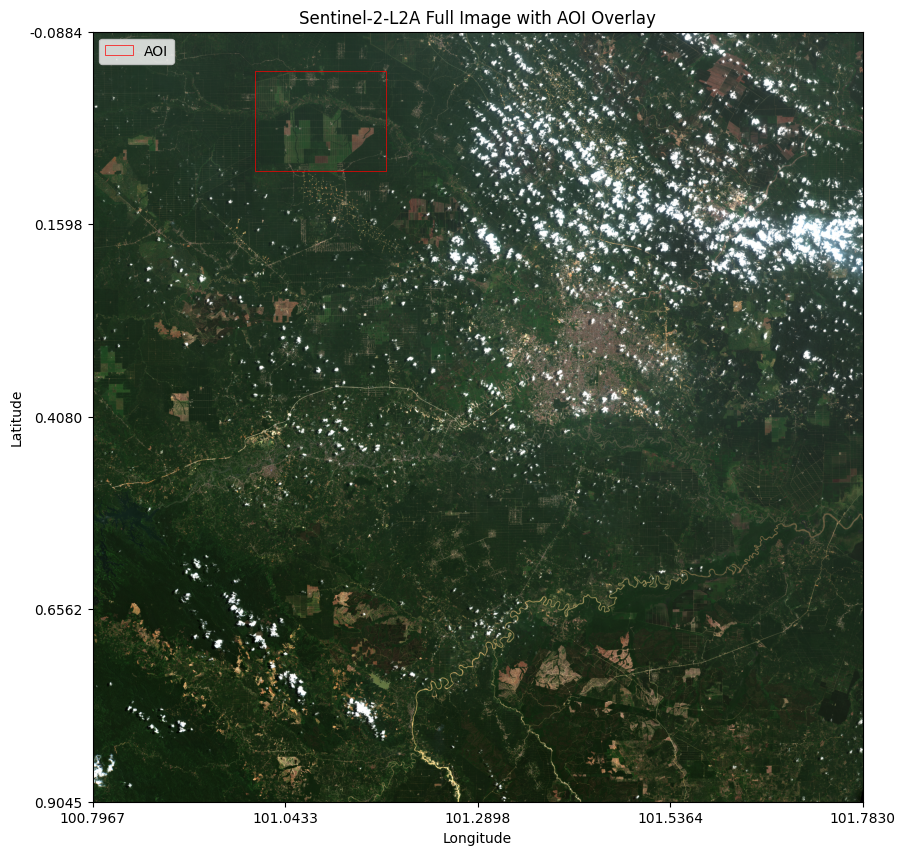

In [ ]:
# Visualise Full Image
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.plot import show
from rasterio.warp import transform_bounds
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Display the full image with a coordinate grid and AOI overlay
with rasterio.open(asset_href) as ds:
    # Read the full dataset (all bands)
    band_data = ds.read()

    # Get the dataset bounds and transform to EPSG:4326 for the grid
    full_bounds = ds.bounds
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(ds.crs, "epsg:4326", *full_bounds)

    # Transform AOI bounds to the image's pixel coordinate system
    aoi_bounds = features.bounds(aoi)  # AOI in EPSG:4326
    aoi_pixel_bounds = windows.from_bounds(
        *warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds),
        transform=ds.transform
    )

# Prepare the RGB image for visualization
rgb_image = np.transpose(band_data, axes=[1, 2, 0])  # Transpose for (height, width, channels)

# Plot the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_image)

# Set extent and overlay coordinate grid
ax.set_xlim(0, rgb_image.shape[1])
ax.set_ylim(rgb_image.shape[0], 0)  # Invert y-axis for image coordinates
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Configure the coordinate grid
lon_ticks = np.linspace(lon_min, lon_max, 5)  # Number of longitude ticks
lat_ticks = np.linspace(lat_min, lat_max, 5)  # Number of latitude ticks

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, rgb_image.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, rgb_image.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

# Add AOI box to the image
rect = plt.Rectangle(
    (aoi_pixel_bounds.col_off, aoi_pixel_bounds.row_off),  # Top-left corner in pixels
    aoi_pixel_bounds.width,  # Width in pixels
    aoi_pixel_bounds.height,  # Height in pixels
    edgecolor="red",
    facecolor="none",
    linewidth=0.5,
    label="AOI"
)
ax.add_patch(rect)

# Add gridlines (optional)
#ax.grid(color='white', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc="upper left")

plt.title(f"Sentinel-2-L2A Full Image")
plt.show()


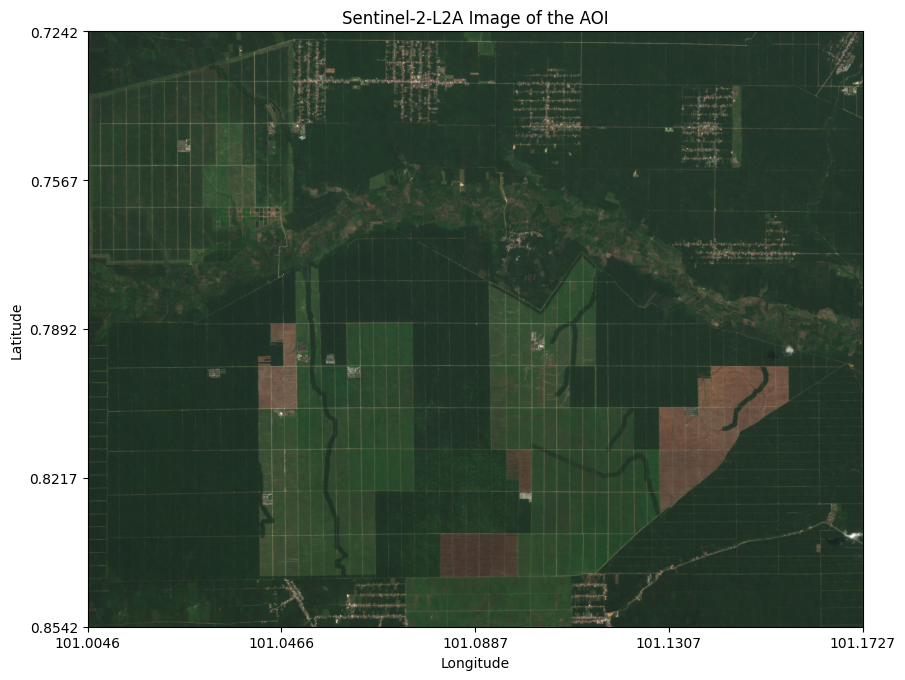

In [ ]:
# Visualise by AOI
# Display the image with a coordinate grid
with rasterio.open(asset_href) as ds:
    # Compute AOI bounds in the raster's CRS
    aoi_bounds = features.bounds(aoi)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)

    # Extract window and bounds for the image
    aoi_window = windows.from_bounds(*warped_aoi_bounds, transform=ds.transform)
    band_data = ds.read(window=aoi_window)

    # Transform raster bounds back to EPSG:4326 for grid overlay
    lon_min, lat_min, lon_max, lat_max = warp.transform_bounds(ds.crs, "epsg:4326", *warped_aoi_bounds)

# Prepare the RGB image for visualization
rgb_image = np.transpose(band_data, axes=[1, 2, 0])  # Transpose for (height, width, channels)

# Plot the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_image)

# Set extent and overlay coordinate grid
ax.set_xlim(0, rgb_image.shape[1])
ax.set_ylim(rgb_image.shape[0], 0)  # Invert y-axis for image coordinates
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Configure the coordinate grid
lon_ticks = np.linspace(lon_min, lon_max, 5)  # Number of longitude ticks
lat_ticks = np.linspace(lat_min, lat_max, 5)  # Number of latitude ticks

ax.xaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, rgb_image.shape[1], len(lon_ticks))))
ax.xaxis.set_major_formatter(mticker.FixedFormatter([f"{lon:.4f}" for lon in lon_ticks]))

ax.yaxis.set_major_locator(mticker.FixedLocator(
    np.linspace(0, rgb_image.shape[0], len(lat_ticks))))
ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{lat:.4f}" for lat in lat_ticks]))

# Rotate y-axis labels for better readability
#for label in ax.yaxis.get_majorticklabels():
    #label.set_rotation(90)  # Rotate labels 90 degrees

# Add gridlines
#ax.grid(color='white', linestyle='--', linewidth=0.5)

plt.title(f"Sentinel-2-L2A Image of the AOI")
plt.show()
